# This notebook serves as walkthrough for planning an experiment for creation through the OT2.
### The following modules are used and should be in the same directory as this notebook: 
* **CreateSamples** is responsible for calculating sample information, which includes component weight fractions and stock volumes
* **OT2Commands** is responsible for setting up information to be interpretted and executed by opentrons.
* **OT2Graphing** contains graphing tools to help visualize and explore parameter spaces.

In [181]:
from Prepare import CreateSamples
from Prepare import OT2Commands as ALH
from Prepare import OT2Graphing as ographing
from opentrons import simulate, execute, protocol_api

# from Prepare import UploadDrive # working on fixing credential issues
import importlib # for reloading packages

## Step 1: Set up the experiment dictionary.
* The first step to planning an experiment is to load the experiment variables and inputs from a csv file. Every variable should have an input with an acceptable datatype. At the moment this step is done by opening a CSV file in Excel, where the first column is the name of the variable and the adjacent column is the variable value. The default delimitter is (,). 
    * Reading directly as csv is fine but it requires you have correctly format strings. This forces you to put marks ('') around each string variable value when planning the experiment. NOTE: You still need to place marks around anything inside a dtype i.e components inside a list ["component 1", component 2"]. However you do not need to place it around numbers or other dtypes.
        * To remove this dependency we can build our own interpreters for our specfic cases such as to not use ast.literal_evals default unpacking.
    * Loading from excel can be done in a similar manner but is avoided due not having xlrd or openpyxl depdenency native to python, and the opentrons being limited in the packages we can add/update. Hence we default to a CSV.
* The experiment dictionary consist of keys being the variable name and the value being the variables value. It is important to always keep in mind the order of every variable is linear and should be assumed to be match all other variables (i.e. Component Shorthand Names index 1 = Component Concentration index 1). This assumption is the default for any function using variables from the experiment dictionary, however we can deviate it from it if needed. 
    * **Note:** Most functions rely on static variable names from the dict (i.e. dict['name']). ***Refrain from changing variable names***

In [182]:
experiment_plan_path = r"C:\Users\Edwin\Desktop\OT2-DOE\PlanPrepareProcess\Prepare\Testing Plans\03_17_21_Ouzo_Search_Saturated.csv"
plan = CreateSamples.get_experiment_plan(experiment_plan_path) 

## Step 1a Optional: Load custom labware dictionary (Remote Testing)
* Provide the path to the directory holding all custom labware. This directory should have custom labware .json files you have previously made and tested, read more here: https://support.opentrons.com/en/articles/3136504-creating-custom-labware-definitions
* The reason we provide this is when working on a device that is not connected to the OT2's Jupyter notebook there is no way to natively use custom labware. So we create a dictionary of custom labware so we can later load into our protocol to primarily simualte and test protocols for execution later once connnected to the OT2's notebook.
    * When using custom labware on the OT2's notebook it pulls from a folder labeled "labware", which is something built into the Opentrons hardware. It has not been tested if the custom labware dictionary will superceed this directory of custom labware if used on the OT2.
    * The custom labware folder should contain everything the OT2 labware folder contains: ADD GDRIVE link to customize
    
* **NOTE: Any function using the custom_labware_dict, the argument is optional so can remove and should receive same output IF working on OT2 computer.**

In [183]:
labware_dir_path = r"C:\Users\Edwin\Desktop\OT2-DOE\PlanPrepareProcess\Prepare\Custom Labware"
custom_labware_dict = ALH.custom_labware_dict(labware_dir_path)

## Step 2: Select and Create Sampling Space
* Create sampling space depending on the units of concentration and method of sampling. All information is pulled from the experimental dictionary made in Step 1.
    * Currently the only sampling method available are simple lattice and random based sampling through the *CreateSamples.generate_candidate_lattice_concentrations* function. There are two potential ways to create samples in a system of n components which currently utilzie the linspaces of concentration. 
        * *Remember the linspace of concentration refers to [minimum concentration, maximum concentration, number of samples]*
    * **Case 1 (Completing case):** Specify all but one (in this case the last) component's concentrations, which with the addition of exposing the unity_filter = True, would calculate the the remaining concentraiton values using the information of the last index of all component related variables (i.e. names). This is only meant for units that require unity like volf, wtf, and molf. 
    * **Case 2 (Non-completing case):** Specify all concentration linspaces, not applying any unit based filters, meant for all other non interdependent units like molarity and mg/mL.
* Other things to take into consideration: All units must be the same for unity based, but not for non-unity units. If you come across a new type of unit, it may be wise to add it to the native functions group of non-unity and unity units (MAKE THIS A SOLID STATIC DICT).

In [184]:
concentration_canidates = CreateSamples.generate_candidate_lattice_concentrations(plan, unity_filter=True)
concentration_canidates

,dppc concentration wtf,dspepeg200 concentration wtf,pfh concentration wtf,ethanol concentration wtf,water concentration wtf
0,0.0001,0.000035,0.000,0.000000,0.999865
1,0.0001,0.000035,0.000,0.044444,0.955421
2,0.0001,0.000035,0.000,0.088889,0.910976
3,0.0001,0.000035,0.000,0.133333,0.866532
4,0.0001,0.000035,0.000,0.177778,0.822087
...,...,...,...,...,...
145,0.0001,0.000035,0.005,0.222222,0.772643
146,0.0001,0.000035,0.005,0.266667,0.728198
147,0.0001,0.000035,0.005,0.311111,0.683754
148,0.0001,0.000035,0.005,0.355556,0.639309


## Step 3: Calculate Volumes of Stocks
From the concentration values calculated in Step 2, we use those along with stock concentration information to calculate the volume of required for each sample.
* This is where things get less "*general*" each case depending on the number of stocks, common components (i.e. component A in both stock A and B) and other requirements will typically require its own function. Luckily given the commmonality of using data frames this should be quite simple. 
    * Currently the only function to calculate volumes in centered around the Ouzo emulsion systems. This system consist of 3 stocks with the solvent being ethanol and two pure stocks of ethanol and water = *CreateSamples.calculate_ouzo_volumes_from_wtf*
    * To identify solutes and solvents in stock the notation of stock is solute1-solute2-.....-soluten-solvent. 

In [185]:
volume_canidates = CreateSamples.calculate_ouzo_volumes_from_wtf(concentration_canidates, plan)

## Step 4: Apply Filters or Other Selection Criteria 

***It is essential to combine both the concentration and volume dataframes made in Step 2 and 3 into one dataframe such that when we apply filters we apply it all samples values. We do this through the *CreateSamples.combine_df* function.***

### Filters: The types of filters can be added easily through dataframe logic, these are current ones in the CreateSamples module: 
   * *pipette_volume_restriction_df* = Given the lower and upper ranges of the two sets of pipettes you will use to synthesize the samples, will remove anything not in range or zero. 
   * *total_volume_restriction_df* = Restrict total volume, mostly based on labware constraints. Column selection based on "total". 
   * *general_max_restriction_df* = provide max value and column name 
   * *general_min_restriction_df* = provide min value and column name 
   
### Other: 
   * *.multiplydf(n, df)* = Will multiply a data frame by n number of times. Useful when making one sample repeatadly.

In [190]:
complete_df_unfiltered = CreateSamples.combine_df_hotdog(concentration_canidates, volume_canidates)

# complete_df_filtered = CreateSamples.pipette_volume_restriction_df(complete_df_unfiltered, 30, 1000, ['N', 'N', 'N', 'N', 'Y'])
complete_df_filtered = CreateSamples.total_volume_restriction_df(complete_df_filtered, 1500)

complete_df_unfiltered

,dppc concentration wtf,dspepeg200 concentration wtf,pfh concentration wtf,ethanol concentration wtf,water concentration wtf,dppc-ethanol-stock uL,dspepeg2000-ethanol-stock uL,pfh-ethanol-stock uL,ethanol-stock uL,water-stock uL,Total Sample Volume uL
0,0.0001,0.000035,0.000,0.000000,0.999865,20.000001,16.633993,0.000000,-36.633994,399.946000,399.946000
1,0.0001,0.000035,0.000,0.044444,0.955421,20.000001,16.633993,0.000000,-19.028166,382.168222,399.774050
2,0.0001,0.000035,0.000,0.088889,0.910976,20.000001,16.633993,0.000000,-1.623356,364.390444,399.401082
3,0.0001,0.000035,0.000,0.133333,0.866532,20.000001,16.633993,0.000000,15.561827,346.612667,398.808488
4,0.0001,0.000035,0.000,0.177778,0.822087,20.000001,16.633993,0.000000,32.507282,328.834889,397.976165
...,...,...,...,...,...,...,...,...,...,...,...
145,0.0001,0.000035,0.005,0.222222,0.772643,20.000001,16.633993,253.164557,-202.775147,309.057111,396.080515
146,0.0001,0.000035,0.005,0.266667,0.728198,20.000001,16.633993,253.164557,-186.373467,291.279333,394.704417
147,0.0001,0.000035,0.005,0.311111,0.683754,20.000001,16.633993,253.164557,-170.276854,273.501556,393.023252
148,0.0001,0.000035,0.005,0.355556,0.639309,20.000001,16.633993,253.164557,-154.507453,255.723778,391.014875


## Step 4a (Optional): Visual
* If you would like, you can visual the space you are sampling by calling up to 3 columns of interest from the componsitional space. The module OT2Graphing will contain helpful function to visualize the sampling space.
* NOTE: Will not work on OT2 explain whyyyy

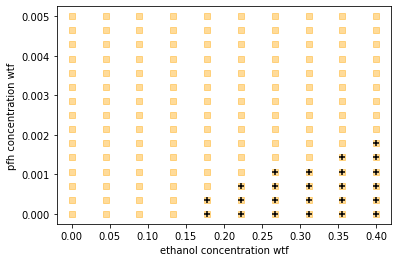

In [191]:
ographing.xy_scatter_df_compare(complete_df_unfiltered, complete_df_filtered, 'ethanol concentration wtf', 'pfh concentration wtf')

## Step 5: Addition of Blanks/Standards
* The most accurate way to blank samples or compare to standards is to create a sample without components of interest for every sample made in the prior dataframes. The way this is done will vary on the case, currently the two cases: 
    * *Common/Dependents Solvents Case:* When components are mixed in solvents for their stock that are part of other components stocks. This case requires you to not only remove the components of interest in the volume side of the dataframe, but if the removed component is part of a stock which contains a common solvent, that removed quantity must find itself back to the common solvent. The upside to this case is there is no need to update the composition/concentration poriton of the dataframe as 
    * *Independent Solvents Case:* This one is simplier as all it requires from the volume side of the dataframe is the zeroing of the volumes, however it requires you to update the compositional/concentration portion of the dataframe.


In [8]:
remove_components = ['dppc concentration wtf', 'dspepeg200 concentration wtf', 'pfh concentration wtf']
add_to = 'water concentration wtf' # if unity unit then do it to the one used to complete 

blank_composition = CreateSamples.blank_sum_to_end(complete_df_filtered, remove_components, add_to)
blank_composition_nr = CreateSamples.remove_duplicates(blank_composition, 3)
blank_volumes = CreateSamples.calculate_ouzo_volumes_from_wtf(blank_composition_nr, plan)
blank_complete_df = CreateSamples.combine_df_hotdog(blank_composition_nr, blank_volumes)

In [9]:
complete_plus_blank = CreateSamples.combine_df_hamburger(complete_df_filtered, blank_complete_df)

# Check to ensure you are covering the appropiate "blanking" space
# ographing.xy_scatter_df_compare(complete_plus_blank, complete_df_filtered, 'ethanol concentration wtf', 'water concentration wtf')

## Step 6: Finalize and Call Seperate Concentration and Volume Dataframes
* Now that we have made the appropiate modification (filtering and addition of blanks/standards) we can finalize our dataframes. We need to seperate them on the basis of concentration and stock volume unit. 
    * At this moment this will only given that samples are the same unit, you should have received an error if this was not the case during the original creation of samples. 
    * We seperate to allow for easier handiling of creating a final dataframe for exporting and reporting volumes to the OT2 for execution/simulation.

In [10]:
final_wtf_df = CreateSamples.isolate_common_column(complete_plus_blank, 'concentration')
final_volume_df = CreateSamples.isolate_common_column(complete_plus_blank, 'stock')
final_volume_df

,dppc-ethanol-stock uL,dspepeg2000-ethanol-stock uL,pfh-ethanol-stock uL,ethanol-stock uL,water-stock uL
0,75.000004,62.377473,0.0,336.064013,999.797500
1,75.000004,62.377473,0.0,479.740702,833.130833
2,75.000004,62.377473,0.0,614.311941,666.464167
3,75.000004,62.377473,0.0,738.832881,499.797500
4,75.000004,62.377473,0.0,852.745468,333.130833
...,...,...,...,...,...
1,0.000000,0.000000,0.0,616.560881,834.000000
2,0.000000,0.000000,0.0,752.208042,666.000000
3,0.000000,0.000000,0.0,876.568121,499.500000
4,0.000000,0.000000,0.0,990.340020,333.000000


## Step 6 (Optional): Calculate Stock Prep Information

* We can calculate stock information to make it easier to prepare these stock. This process if semi-general, supporting a few stock concentration units = mgperml, volf, wtf, molf and molarity. All of these require the basis of volume as that is what is driving how much sample we make for the OT2. 
    * *Reccomended*: Use at the minimum the default buffering (extra stock being made) of 40 percent as from anacdotal use this will ensure you do not aspirate any air by mistake.
    * To do: So acutally have it print with concentration, just in case you go over and you can edit make some sort of fill in table and also have it return custom labels for label machine. 

In [11]:
chem_database_path = r"C:\Users\Edwin\Desktop\OT2-DOE\PlanPrepareProcess\Prepare\Chemical Database.xlsx"
stock_prep_df = CreateSamples.calculate_stock_prep_df(plan, final_volume_df, chem_database_path, buffer_pct=2)


## Step 7: Set up Ranges for Stocks
* It is important to know how many stock container will be needed for each stock and be able to provide the correct instructions for OT2 commands to follow.
    * The ranges of stock refers to the ranges of wells one stock will cover. The range is provided in terms of the index of the stock volume dataframe i.e.([lower, upper])). The format is as follows = [[stock1_range1, stock1_range2....], [stock2_range1, stock2_range2....] []...].
    * The basis of range is on the maximum volume of the stock container, however currently limitation are: 
        * All stock containers must be the same
        * Each component must have its own stock - need to test verify

In [12]:
importlib.reload(ALH)

<module 'Prepare.OT2Commands' from 'C:\\Users\\Edwin\\Desktop\\OT2-DOE\\PlanPrepareProcess\\Prepare\\OT2Commands.py'>

In [15]:
max_source_vol = 15000
stock_ranges = ALH.stock_well_ranges(final_volume_df, max_source_vol)
stock_ranges

dppc-ethanol-stock uL position(s) = [1] for wells [[0, 64]]
dspepeg2000-ethanol-stock uL position(s) = [2] for wells [[0, 64]]
pfh-ethanol-stock uL position(s) = [3] for wells [[0, 64]]
ethanol-stock uL position(s) = [4, 5, 6] for wells [[0, 26], [26, 60], [60, 64]]
water-stock uL position(s) = [7, 8, 9] for wells [[0, 25], [25, 51], [51, 64]]


[[[0, 64]],
 [[0, 64]],
 [[0, 64]],
 [[0, 26], [26, 60], [60, 64]],
 [[0, 25], [25, 51], [51, 64]]]

# Step 8: Simulate/Execute
* The main information needed to create commands for the OT2 is the position of the stocks and the volumes in respect to each well you would like to move the stock to. All volumes in sent to the OT2 will be interpretted as microliters (uL). 
    * Stock Volumes: We have calculated this in step 3. It should be assumed we are making each sample in consecutive order (in order of the dataframe index). The way we prepare these samples can vary, which is what were refer to as the *pipetteing strategy*.
        * Pipetting Strategy 1: Add each stock to all wells then move onto next stock. The upside to this is the simplicity of the written protocol. It has a downside of using more tips, however parking the tip on the tiprack may resolve this (it is already being done when switching between pipettes). Also it can allow for evaporation or other time sensitve process to occur in the time between stock additions. **THIS IS CURRENTLY BEING USED DUE TO SIMPLICITY**. 
        * Pipetting Strategy 2: Adding all stocks to a well then moving on.  
        
* The way the OT2 protocols work can be read about here: https://docs.opentrons.com/v2/. Focus on the controlling with python sections. However generally this is the workflow (might add a graphic):
    1. Initiate Protocol: A protocol object must be called and this is what is essentially the brains of the process. Each protcol object is unique and you must keep track of the one you are using, so feel free to name it anything. Protocols can either be called as a simualtion or a execution. This object will allow use to initialize all labware, instrumentation and commands to the OT2. 
    2. Initiate Labware: Using the protocol object, we can call labware objects and assign them a variable name and place on the OT2 deck. All that is needed is the protocol object, name of labware (which must exist in either the native or custom directory of labwares) and the slot number. 
        * The main use of the labware is to call a well as to use an argument in a command function. These well arguments are formatted as a string, knowing this allows us to concatanate more than two labwares (i.e. 2 96 well plates) into one list to making calling more easier without having to switch labware objects. 
    3. Initiate Pipettes: Using the protocol object, we can call instrument objects which behave similarly to labware objects. These pipettes have methods which are the OT2 commands.
    4. Liquid Handling Commands: Move, Distribute, Transfer


* Currently this workflow is only split up between the initiation of the protocol/labware/pipette (***OT2Commands.loading_labware***) and the liquid handling command with the intializing step returning a dictionary with the appropiate object ready for liquid handling commands (***OT2Commands.pipette_stock_volumes***) once fed into another function. 


* ***OT2Commands.pipette_stock_volumes*** does something notable which you may want to follow in other protocols. It returns the well of every sample created in the order it was made in a list. This list is useful when populating information in the final dataframe meant for exporting and storage.

In [16]:
protocol = simulate.get_protocol_api('2.0', extra_labware=custom_labware_dict)
loaded_dict = ALH.loading_labware(protocol, plan)
info = ALH.pipette_stock_volumes(protocol, loaded_dict, final_volume_df, stock_ranges)

C:\Users\Edwin\.opentrons\robot_settings.json not found. Loading defaults
C:\Users\Edwin\.opentrons\deck_calibration.json not found. Loading defaults


Picking up tip from A1 of Opentrons 96 Tip Rack 300 µL on 10
Distributing [75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.0000043545

Blowing out at A1 of Opentrons Fixed Trash on 12
Aspirating 952.7454683203231 uL from A4 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 500.0 uL/sec
Dispensing 852.7454683203231 uL into A5 of Falcon 48 Well Plate 1500 ÂµL on 2 at 1000.0 uL/sec
Blowing out at A1 of Opentrons Fixed Trash on 12
Aspirating 578.0113403462452 uL from A4 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 500.0 uL/sec
Dispensing 478.0113403462452 uL into A6 of Falcon 48 Well Plate 1500 ÂµL on 2 at 1000.0 uL/sec
Blowing out at A1 of Opentrons Fixed Trash on 12
Aspirating 871.9810604746758 uL from A4 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 500.0 uL/sec
Dispensing 478.0113403462452 uL into A6 of Falcon 48 Well Plate 1500 ÂµL on 2 at 1000.0 uL/sec
Dispensing 293.9697201284306 uL into A7 of Falcon 48 Well Plate 1500 ÂµL on 2 at 1000.0 uL/sec
Blowing out at A1 of Opentrons Fixed Trash on 12
Aspirating 537.6464099050927 uL from A4 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 500.0 uL/sec


Blowing out at A1 of Opentrons Fixed Trash on 12
Aspirating 765.1308333333333 uL from B4 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 500.0 uL/sec
Dispensing 665.1308333333333 uL into A2 of Falcon 48 Well Plate 1500 ÂµL on 3 at 1000.0 uL/sec
Blowing out at A1 of Opentrons Fixed Trash on 12
Aspirating 598.4641666666666 uL from B4 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 500.0 uL/sec
Dispensing 498.46416666666664 uL into A3 of Falcon 48 Well Plate 1500 ÂµL on 3 at 1000.0 uL/sec
Blowing out at A1 of Opentrons Fixed Trash on 12
Dropping tip into A1 of Opentrons Fixed Trash on 12
Picking up tip from A2 of Opentrons 96 Tip Rack 1000 µL on 11
Transferring 331.79750000000007 from C1 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 to A4 of Falcon 48 Well Plate 1500 ÂµL on 3
Aspirating 331.79750000000007 uL from C1 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 500.0 uL/sec
Dispensing 331.79750000000007 uL into A4 of Falcon 48 Well Plate 1500 ÂµL on 3 at 1000.0 uL/sec

In [17]:
final_place = ALH.transfer_from_destination_to_final(protocol, loaded_dict, plan, len(final_volume_df)) # to get rid of the experiment_csv_dict requirement you could make the addition of labware a seperate part/function

Picking up tip from A1 of Opentrons 96 Tip Rack 300 µL on 10
Distributing [75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.00000435450026, 75.0000043545

Aspirating 253.16455696202533 uL from A3 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 150.0 uL/sec
Dispensing 253.16455696202533 uL into E6 of Falcon 48 Well Plate 1500 ÂµL on 2 at 300.0 uL/sec
Transferring 253.16455696202533 from A3 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 to E7 of Falcon 48 Well Plate 1500 ÂµL on 2
Aspirating 253.16455696202533 uL from A3 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 150.0 uL/sec
Dispensing 253.16455696202533 uL into E7 of Falcon 48 Well Plate 1500 ÂµL on 2 at 300.0 uL/sec
Transferring 253.16455696202533 from A3 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 to E8 of Falcon 48 Well Plate 1500 ÂµL on 2
Aspirating 253.16455696202533 uL from A3 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 150.0 uL/sec
Dispensing 253.16455696202533 uL into E8 of Falcon 48 Well Plate 1500 ÂµL on 2 at 300.0 uL/sec
Transferring 253.16455696202533 from A3 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 to F1 of Falcon 48 Well Plate 1500 Â

Dispensing 665.7974999999999 uL into D3 of Falcon 48 Well Plate 1500 ÂµL on 2 at 1000.0 uL/sec
Blowing out at A1 of Opentrons Fixed Trash on 12
Aspirating 931.5950000000001 uL from B4 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 500.0 uL/sec
Dispensing 499.1308333333334 uL into D4 of Falcon 48 Well Plate 1500 ÂµL on 2 at 1000.0 uL/sec
Dispensing 332.46416666666676 uL into D5 of Falcon 48 Well Plate 1500 ÂµL on 2 at 1000.0 uL/sec
Blowing out at A1 of Opentrons Fixed Trash on 12
Aspirating 765.2795833333333 uL from B4 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 500.0 uL/sec
Dispensing 165.79750000000004 uL into D6 of Falcon 48 Well Plate 1500 ÂµL on 2 at 1000.0 uL/sec
Dispensing 499.4820833333333 uL into D7 of Falcon 48 Well Plate 1500 ÂµL on 2 at 1000.0 uL/sec
Blowing out at A1 of Opentrons Fixed Trash on 12
Aspirating 599.4820833333333 uL from B4 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 500.0 uL/sec
Dispensing 499.4820833333333 uL into D7 of Falcon 48 Well 

# Step 9: Format for Exporting and Upload to Google Drive
* Using the information from our previously created dataframes we create a final dataframe to convert to a csv and upload to google drive for storage. 
    * Currently the two main pieces of information uploaded are composition of sample and sample location information. This for each sample is tied to a unique ID which contains a well_timestamp_keyword. 
    * Other information you can add is stock information or stock volumes or even metadata from the opentrons (?? this would could/could not include thing like aspiration rate since this might/might not be in the experiment plan which would ideally be uploaded as well. 

* Currently the function *CreateSamples.create_df* uses information from *ALH.pipette_stock_volumes* along with the values of the composition dataframe and experiment dict to create a final df for exporting. It is not super general so will work on seperating the information slicing and dataframe combination - its quite tangeled and can be generalized. 

* Once you create your dataframe (where every row/index = one unique sample) then we can convert it to a csv and upload to google drive.

***URGENT CHANGE: HANDLING AS CSV INSIDE OF CREATE_DF FUNCTION CHANGE TO ONLY HANDLE AS DF, PREVENT LOSS IN CONVERSIONS"

In [18]:
importlib.reload(CreateSamples)

<module 'Prepare.CreateSamples' from 'C:\\Users\\Edwin\\Desktop\\OT2-DOE\\PlanPrepareProcess\\Prepare\\CreateSamples.py'>

In [23]:
export_df = CreateSamples.create_df(info['info concat'][0], final_wtf_df.values, plan, unique_identifier='Right')
export_df = CreateSamples.combine_df_hotdog(export_df, final_volume_df) # unfiltered

# sample_info_hold = export_df.to_csv(r"03_16_21 Experiment Synthesis Info", index=False)
export_df

,UID,dppc wtf,dspepeg200 wtf,pfh wtf,ethanol wtf,water wtf,Well,Labware,Slot,dppc-ethanol-stock uL,dspepeg2000-ethanol-stock uL,pfh-ethanol-stock uL,ethanol-stock uL,water-stock uL
0,S2_A1_03-17-2021_Right,0.0001,0.000035,0.0,0.333333,0.666532,A1,Falcon 48 Well Plate 1500 ÂµL,2,75.000004,62.377473,0.0,336.064013,999.797500
1,S2_A2_03-17-2021_Right,0.0001,0.000035,0.0,0.444444,0.555421,A2,Falcon 48 Well Plate 1500 ÂµL,2,75.000004,62.377473,0.0,479.740702,833.130833
2,S2_A3_03-17-2021_Right,0.0001,0.000035,0.0,0.555556,0.444309,A3,Falcon 48 Well Plate 1500 ÂµL,2,75.000004,62.377473,0.0,614.311941,666.464167
3,S2_A4_03-17-2021_Right,0.0001,0.000035,0.0,0.666667,0.333198,A4,Falcon 48 Well Plate 1500 ÂµL,2,75.000004,62.377473,0.0,738.832881,499.797500
4,S2_A5_03-17-2021_Right,0.0001,0.000035,0.0,0.777778,0.222087,A5,Falcon 48 Well Plate 1500 ÂµL,2,75.000004,62.377473,0.0,852.745468,333.130833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,S3_B4_03-17-2021_Right,0.0000,0.000000,0.0,0.444000,0.556000,B4,Falcon 48 Well Plate 1500 ÂµL,3,0.000000,0.000000,0.0,616.560881,834.000000
60,S3_B5_03-17-2021_Right,0.0000,0.000000,0.0,0.556000,0.444000,B5,Falcon 48 Well Plate 1500 ÂµL,3,0.000000,0.000000,0.0,752.208042,666.000000
61,S3_B6_03-17-2021_Right,0.0000,0.000000,0.0,0.667000,0.333000,B6,Falcon 48 Well Plate 1500 ÂµL,3,0.000000,0.000000,0.0,876.568121,499.500000
62,S3_B7_03-17-2021_Right,0.0000,0.000000,0.0,0.778000,0.222000,B7,Falcon 48 Well Plate 1500 ÂµL,3,0.000000,0.000000,0.0,990.340020,333.000000


# Navigate/Create (to) respective folder on Google Drive
1. Call an instance of your google drive, this is statically the Pozzo Team Drive using *CreateSamples.team_drive_dict()*. This should open a new window prompting you for credentials. It will also return a dictionary of the highest level folders name and unique ID. **The unique ID is what will let you navigate**
2. Once inside the Team Drive use *CreateSamples.file_and_folder_navi(unique_ID)* by selecting a certain root level folder from step 1. Then you can keep repeating this until you reach the level/directory of interest.
    * A way to bypass this is to log into google drive and find the unique ID manually EXPLAIN
3. Once you have reached the level of interest, create the folder if necessary. 
4. With the folder ID of interest then use *upload_to_team_drive_folder* providing the path and name of file along with final destination (the ID you found/made from step 2/3). This will upload the respective files to that level. 
5. Cry




* Add the option to create a new folder - as a function to the package. 
* looks like OT2 can not at all upload any sort of package - so will need to make it clear to only use the drive portion of package on remote computer - hence why we should switch to using the module and having notebooks ayt surface level.

In [ ]:
from Prepare import UploadDrive
importlib.reload(UploadDrive)

In [ ]:
UploadDrive.initialize_connection(r"C:\Users\Edwin\Desktop\OT2creds.txt")

In [ ]:
UploadDrive.team_drive_dict(r"C:\Users\Edwin\Desktop\OT2creds.txt")

In [ ]:
current_members = UploadDrive.file_and_folder_navi('1dXYmxuESNhgmVHntEf8hnZmjK0Br8b64')
# UploadDrive.file_and_folder_navi('1CDnoLE32bG0BFhhvCl5JlRFO4I_ga-eJ')

In [ ]:
plan_file_path = experiment_plan_path
synthesis_info_file_path = r"sample_info"
folder_to_place_id = '1YdAqr1kYFEuRc8wyd9dcyzo0BWW68-1P'

# CreateSamples.upload_to_team_drive_folder(folder_to_place_id, plan_file_path, 'Experiment Plan Info')
CreateSamples.upload_to_team_drive_folder(folder_to_place_id, synthesis_info_file_path, 'Experiment Synthesis Info')